In [1]:
import os

import arviz as az
import bambi as bmb
from IPython.display import display
import pandas as pd
import seaborn as sns
import torch

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
sns.set_theme(style="darkgrid")

In [3]:
num_test = 500

# Load data

In [4]:
models = ["bert", "gpt2"]
_accuracy_dfs = []

for model in models:
    accuracies_dir = os.path.join("accuracies_from_paper", str(num_test), model)
    _dfs = []
    for dataset in sorted(os.listdir(accuracies_dir)):
        _df = pd.read_csv(os.path.join(accuracies_dir, dataset, "accuracies.csv"))
        _df["dataset"] = dataset
        _dfs.append(_df)
    _accuracy_df = pd.concat(_dfs)
    _accuracy_df["model"] = model
    _accuracy_df = _accuracy_df[["model", "dataset", "base", "extra", "test"]]
    _accuracy_dfs.append(_accuracy_df)
accuracy_df = pd.concat(_accuracy_dfs)

In [5]:
num_correct_df = (accuracy_df.copy()[["base", "extra", "test"]] * num_test).astype(
    int, errors="raise"
)
num_correct_df["dataset"] = accuracy_df["dataset"].copy()
num_correct_df["model"] = accuracy_df["model"].copy()
num_correct_df = num_correct_df[["model", "dataset", "base", "extra", "test"]]
num_correct_df["pair"] = range(len(num_correct_df))
num_correct_df

,model,dataset,base,extra,test,pair
0,bert,ag_news,403,432,430,0
1,bert,ag_news,309,408,427,1
2,bert,ag_news,340,424,433,2
3,bert,ag_news,333,436,422,3
4,bert,ag_news,285,419,405,4
...,...,...,...,...,...,...
15,gpt2,yelp_review_full,117,104,92,795
16,gpt2,yelp_review_full,129,100,109,796
17,gpt2,yelp_review_full,119,113,107,797
18,gpt2,yelp_review_full,155,117,115,798


In [6]:
def stat_model(
    num_correct_df: pd.DataFrame, control_column: str, treatment_column: str
) -> tuple[bmb.Model, az.InferenceData]:
    df = (
        num_correct_df[["pair", "model", "dataset", control_column, treatment_column]]
        .melt(["pair", "model", "dataset"], var_name="method", value_name="num_correct")
        .sort_values("pair")
        .reset_index(drop=True)
    )
    # Pairs/subsamples were formed from the dataset. So it's nested, not crossed.
    # Technically, crossed notation—(1|dataset) + (1|pair)—would still result in a
    # nested inference b/c pair is uniquely coded
    model = bmb.Model(
        "num_correct ~ method + (1|model) + (1|dataset/pair)", family="poisson", data=df
    )
    inference_method = "mcmc" if not torch.cuda.is_available() else "nuts_numpyro"
    fit_summary: az.InferenceData = model.fit(
        inference_method=inference_method, chains=1, random_seed=123, cores=1
    )
    az_summary: pd.DataFrame = az.summary(fit_summary)
    display(
        az_summary.loc[
            [index_name for index_name in az_summary.index if "method" in index_name]
        ]
    )

    az.plot_trace(fit_summary, compact=False, var_names="method", filter_vars="like")
    return model, fit_summary

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [Intercept, method, 1|model_sigma, 1|model_offset, 1|dataset_sigma, 1|dataset_offset, 1|dataset:pair_sigma, 1|dataset:pair_offset]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 2051 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
method[extra],0.095,0.003,0.089,0.102,0.0,0.0,769.0,298.0,NaN


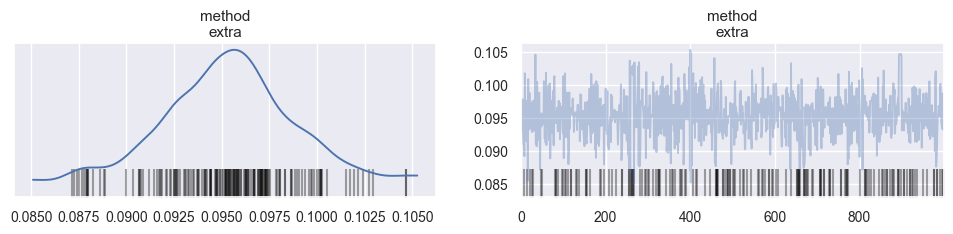

In [7]:
model_control, summary_control = stat_model(
    num_correct_df, control_column="base", treatment_column="extra"
)

In [8]:
print(model_control)

       Formula: num_correct ~ method + (1|model) + (1|dataset/pair)
        Family: poisson
          Link: mu = log
  Observations: 1600
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 3.5355)
            method ~ Normal(mu: 0.0, sigma: 5.0)
        
        Group-level effects
            1|model ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 3.5355))
            1|dataset ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 3.5355))
            1|dataset:pair ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 3.5355))
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [Intercept, method, 1|model_sigma, 1|model_offset, 1|dataset_sigma, 1|dataset_offset, 1|dataset:pair_sigma, 1|dataset:pair_offset]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 2189 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
method[test],-0.001,0.004,-0.008,0.006,0.0,0.0,339.0,299.0,NaN


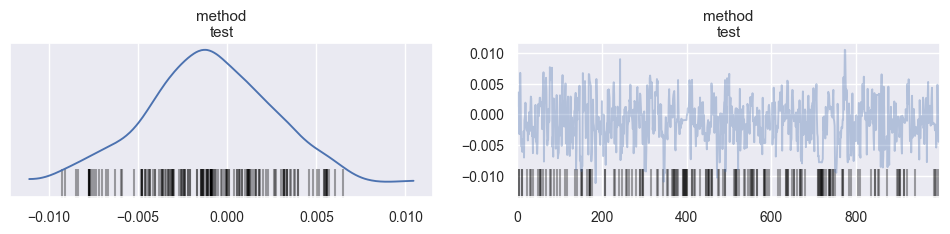

In [9]:
model_bias, summary_bias = stat_model(
    num_correct_df, control_column="extra", treatment_column="test"
)

In [10]:
print(model_bias)

       Formula: num_correct ~ method + (1|model) + (1|dataset/pair)
        Family: poisson
          Link: mu = log
  Observations: 1600
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 3.5355)
            method ~ Normal(mu: 0.0, sigma: 5.0)
        
        Group-level effects
            1|model ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 3.5355))
            1|dataset ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 3.5355))
            1|dataset:pair ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 3.5355))
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()
